# Import Packages

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Data Preparation

In [27]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_size = int(0.6 * len(mnist))
val_size = int(0.2 * len(mnist))
test_size = len(mnist) - train_size - val_size
train_data, val_data, test_data = random_split(mnist, [train_size, val_size, test_size])
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# CNN Architecture

In [28]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.norm1 = nn.LayerNorm([32, 28, 28])
        self.norm2 = nn.LayerNorm([64, 14, 14])
        self.fc1 = nn.Linear(3136, 128)
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = self.pool(self.norm1(torch.relu(self.conv1(x))))
        x = self.pool(self.norm2(torch.relu(self.conv2(x))))
        x = x.view(x.size(0), -1)
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Training Function

In [29]:
def train_model(model, train_loader, val_loader, epochs=10, lr=0.01):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

        # Validation loss
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        val_losses.append(val_loss / len(val_loader))

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

    return train_losses, val_losses

# Plotting

In [30]:
def plot_metrics(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

# Testing

In [31]:
def test_model(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    total = 0  # Total number of samples
    correct = 0  # Number of correctly classified samples
    all_preds = []
    all_labels = []

    with torch.no_grad():  # No gradient calculation during testing
        for images, labels in test_loader:
            outputs = model(images)
            _, preds = torch.max(outputs, 1)  # Get the class with the highest score
            total += labels.size(0)  # Increment total samples
            correct += (preds == labels).sum().item()  # Count correct predictions
            all_preds.extend(preds.cpu().numpy())  # Save predictions
            all_labels.extend(labels.cpu().numpy())  # Save true labels

    # Calculate accuracy
    accuracy = correct / total * 100
    print(f"Test Accuracy: {accuracy:.2f}%")

    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    ConfusionMatrixDisplay(cm).plot(cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()

# Running the code

Epoch 1/10, Train Loss: 0.3489, Val Loss: 0.1101
Epoch 2/10, Train Loss: 0.1070, Val Loss: 0.0680
Epoch 3/10, Train Loss: 0.0777, Val Loss: 0.0539
Epoch 4/10, Train Loss: 0.0610, Val Loss: 0.0589
Epoch 5/10, Train Loss: 0.0506, Val Loss: 0.0496
Epoch 6/10, Train Loss: 0.0425, Val Loss: 0.0426
Epoch 7/10, Train Loss: 0.0371, Val Loss: 0.0396
Epoch 8/10, Train Loss: 0.0314, Val Loss: 0.0378
Epoch 9/10, Train Loss: 0.0280, Val Loss: 0.0360
Epoch 10/10, Train Loss: 0.0257, Val Loss: 0.0381


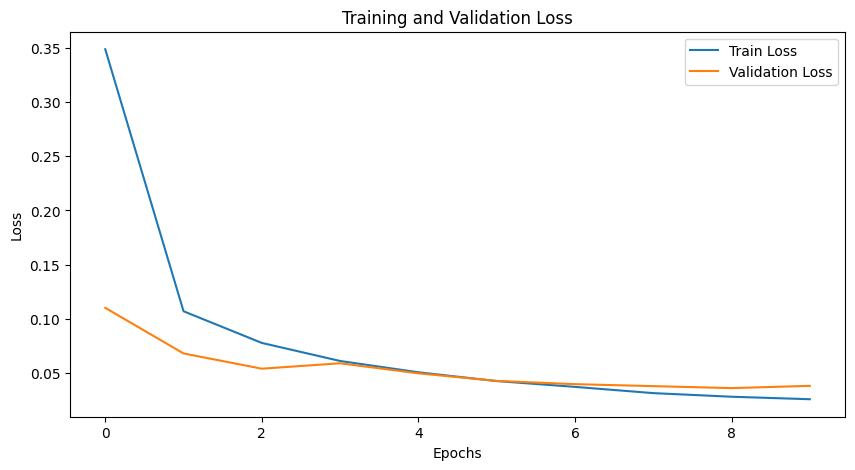

Test Accuracy: 98.91%


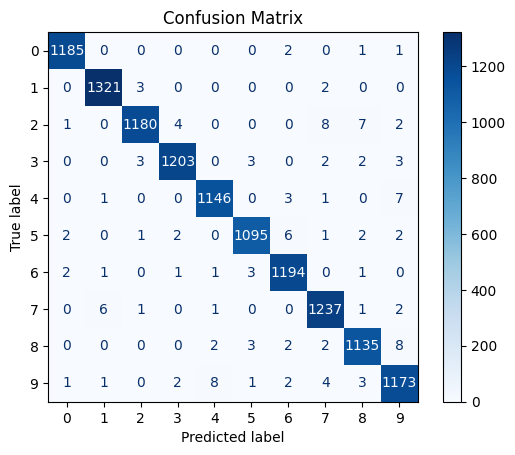

In [32]:
model = CNN()
train_losses, val_losses = train_model(model, train_loader, val_loader, epochs=10, lr=0.01)
plot_metrics(train_losses, val_losses)
test_model(model, test_loader)